In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
import numpy as np

# chargement jeu de donnée avec le moins de features
df = pd.read_csv('dataset_test4.csv')

# separation variables indépendante et variable dépendante(target)
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']



cat_vars = X.select_dtypes(include=['object']).columns.tolist() + ['UrbanRural'] + ['FranchiseBinary']
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars.remove('UrbanRural') 
num_vars.remove('FranchiseBinary') 

# num transform
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])
# cat transform
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary')),
])

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# pipeline xgboost
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1, max_depth=15, min_child_weight=16))
])

# separation des données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=0.05, random_state=42, stratify=y)

# fit sur l'ensemble d'entrainement 
xgboost_pipeline.fit(X_train, y_train)

# obtenir le nombre de caractéristiques transformées
feature_names = xgboost_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"Nombre de caractéristiques après le prétraitement : {len(feature_names)}")

# utilisation de la modelisation pour predire X test
y_pred = xgboost_pipeline.predict(X_test)

# evaluation du modele
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(report)


Nombre de caractéristiques après le prétraitement : 137
0.9462471505361214
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     27660
           1       0.89      0.86      0.88      7873

    accuracy                           0.95     35533
   macro avg       0.93      0.92      0.92     35533
weighted avg       0.95      0.95      0.95     35533



In [2]:
cat_vars, num_vars

(['State',
  'BankState',
  'RevLineCr',
  'LowDoc',
  'Industry',
  'UrbanRural',
  'FranchiseBinary'],
 ['Zip', 'NAICS', 'Term', 'NoEmp', 'FranchiseCode'])

In [3]:
new_data = pd.DataFrame({
    'State': ['NH', 'CA', 'NJ'],  
    'BankState': ['NH', 'CA', 'NJ'],  
    'RevLineCr': ['Y', 'N', 'N'],
    'LowDoc': ['Y', 'N', 'N'], 
    'UrbanRural': [0, 1, 0],
    'FranchiseBinary': [0, 1, 0],
    'Zip': [47711, 47711, 0],
    'NAICS': [451120, 451120, 0],
    'Term': [84, 240, 45],
    'NoEmp': [2, 5, 10],
    'FranchiseCode': [0, 1, 0],
    'Industry': ['Retail_trade', 'Retail_trade', 'Arts/Entertain/Rec'],
})

# faire des prédictions avec le modèle optimisé
new_y_ped = xgboost_pipeline.predict(new_data)

# ajouter les prédictions à new_data
new_data['1->NO  0->YES'] = new_y_ped

print(new_data)

  State BankState RevLineCr LowDoc  UrbanRural  FranchiseBinary    Zip  \
0    NH        NH         Y      Y           0                0  47711   
1    CA        CA         N      N           1                1  47711   
2    NJ        NJ         N      N           0                0      0   

    NAICS  Term  NoEmp  FranchiseCode            Industry  1->NO  0->YES  
0  451120    84      2              0        Retail_trade              0  
1  451120   240      5              1        Retail_trade              0  
2       0    45     10              0  Arts/Entertain/Rec              1  


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# chargement jeu de données avec le plus de features avec rf baseline

df = pd.read_csv('dataset_test1.csv')

# separation variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']


cat_vars = X.select_dtypes(include=['object']).columns.tolist() + ['NewExist'] + ['UrbanRural'] + ['FranchiseBinary'] 
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars.remove('NewExist')  
num_vars.remove('UrbanRural') 
num_vars.remove('FranchiseBinary') 

# num transform
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])
# cat transform

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])
#preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# pipeline rf
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# separation des données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# fit le modele sur l'ensemble de test
rf_pipeline.fit(X_train, y_train)

# obtenir le nombre de caractéristiques transformées
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"Nombre de caractéristiques après le prétraitement : {len(feature_names)}")

# utilisation du modele pour predire sur X test
y_pred = rf_pipeline.predict(X_test)

# evaluation du modele
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy, report)


Nombre de caractéristiques après le prétraitement : 142
0.9351302671479128               precision    recall  f1-score   support

           0       0.94      0.98      0.96    110637
           1       0.91      0.78      0.84     31494

    accuracy                           0.94    142131
   macro avg       0.93      0.88      0.90    142131
weighted avg       0.93      0.94      0.93    142131



In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import numpy as np

#chargement jeu de donnée avec le plus de features avec xgboost et catboost
df = pd.read_csv('dataset_test1.csv')

# sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']


cat_vars = X.select_dtypes(include=['object']).columns.tolist() + ['NewExist'] + ['UrbanRural'] + ['FranchiseBinary']
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars.remove('NewExist')  
num_vars.remove('UrbanRural') 
num_vars.remove('FranchiseBinary') 

#num transform
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])
#cat transform
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary')),
])


#preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars),
    ])

#pipeline xgboost
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(max_depth=10, random_state=42))
])
#CatBoostClassifier(max_depth=10, random_state=42)
#XGBClassifier(n_estimators = 100, random_state=42, n_jobs=-1,max_depth=16, min_child_weight=14)

# séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=0.05, random_state=42, stratify=y)

# ajustement de la pipeline sur les données d'entraînement
xgboost_pipeline.fit(X_train, y_train)

# obtenir le nombre de caractéristiques transformées
feature_names = xgboost_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"Nombre de caractéristiques après le prétraitement : {len(feature_names)}")

# prediction sur l'ensemble x test
y_pred = xgboost_pipeline.predict(X_test)

# evaluation du modele
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
f1_macro= f1_score(y_test, y_pred, average='macro')

print(accuracy)
print(report)
print(f1_macro)


Learning rate set to 0.166372
0:	learn: 0.5075791	total: 116ms	remaining: 1m 56s
1:	learn: 0.4212339	total: 222ms	remaining: 1m 50s
2:	learn: 0.3584946	total: 335ms	remaining: 1m 51s
3:	learn: 0.3237095	total: 436ms	remaining: 1m 48s
4:	learn: 0.2991734	total: 537ms	remaining: 1m 46s
5:	learn: 0.2793798	total: 639ms	remaining: 1m 45s
6:	learn: 0.2579336	total: 749ms	remaining: 1m 46s
7:	learn: 0.2496270	total: 851ms	remaining: 1m 45s
8:	learn: 0.2395126	total: 971ms	remaining: 1m 46s
9:	learn: 0.2281199	total: 1.08s	remaining: 1m 47s
10:	learn: 0.2233658	total: 1.2s	remaining: 1m 47s
11:	learn: 0.2159745	total: 1.33s	remaining: 1m 49s
12:	learn: 0.2120344	total: 1.45s	remaining: 1m 50s
13:	learn: 0.2084827	total: 1.58s	remaining: 1m 51s
14:	learn: 0.2053736	total: 1.71s	remaining: 1m 52s
15:	learn: 0.2030110	total: 1.82s	remaining: 1m 52s
16:	learn: 0.1991830	total: 1.93s	remaining: 1m 51s
17:	learn: 0.1968052	total: 2.05s	remaining: 1m 51s
18:	learn: 0.1943829	total: 2.16s	remaining: 

In [6]:
# Obtenir les importances des caractéristiques du modèle XGBoost
feature_importances = xgboost_pipeline.named_steps['classifier'].feature_importances_

# Obtenir les noms des caractéristiques transformées
feature_names = xgboost_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Afficher les importances des caractéristiques
print(importance_df)

                        Feature  Importance
2                     num__Term   36.563356
1                    num__NAICS   11.283051
133  cat__Industry_Retail_trade    9.043598
8                 num__SBA_Appv    4.557717
115            cat__RevLineCr_Y    3.505415
..                          ...         ...
131  cat__Industry_Public_Admin    0.000541
109           cat__BankState_VI    0.000000
72            cat__BankState_GU    0.000000
127     cat__Industry_Mgmt_comp    0.000000
62            cat__BankState_AN    0.000000

[142 rows x 2 columns]


In [7]:
import pickle
with open('best_model.pkl', 'wb') as fichier:
    pickle.dump(xgboost_pipeline, fichier)

In [8]:
with open('best_model.pkl', 'rb') as fichier:
        modele_charge = pickle.load(fichier)

In [9]:
cat_vars, num_vars

(['State',
  'BankState',
  'RevLineCr',
  'LowDoc',
  'Industry',
  'NewExist',
  'UrbanRural',
  'FranchiseBinary'],
 ['Zip',
  'NAICS',
  'Term',
  'NoEmp',
  'CreateJob',
  'RetainedJob',
  'FranchiseCode',
  'GrAppv',
  'SBA_Appv'])

In [10]:
new_data = pd.DataFrame({
    'State': ['NH', 'CA', 'NJ'],  
    'BankState': ['NH', 'CA', 'NJ'],  
    'RevLineCr': ['Y', 'N', 'N'],
    'LowDoc': ['Y', 'N', 'N'],
    'NewExist': [1,2,2],  
    'UrbanRural': [0, 1, 0],
    'FranchiseBinary': [0, 1, 0],
    'Zip': [47711, 47711, 0],
    'NAICS': [451120, 451120, 7083],
    'Term': [84, 240, 45],
    'NoEmp': [2, 5, 45],
    'CreateJob': [0,7, 0],
    'RetainedJob': [0, 1, 0],
    'FranchiseCode': [0, 1, 0],
    'GrAppv': [60000.0, 287000.0, 600000.0],
    'SBA_Appv': [32000.0, 215250.0, 499998.0],
    'Industry': ['Retail_trade', 'Retail_trade', 'Arts/Entertain/Rec'],
})

# faire des prédictions avec le modèle optimisé
new_y_ped = xgboost_pipeline.predict(new_data)

# ajouter les prédictions à new_data
new_data['1->NO  0->YES'] = new_y_ped

print(new_data)

  State BankState RevLineCr LowDoc  NewExist  UrbanRural  FranchiseBinary  \
0    NH        NH         Y      Y         1           0                0   
1    CA        CA         N      N         2           1                1   
2    NJ        NJ         N      N         2           0                0   

     Zip   NAICS  Term  NoEmp  CreateJob  RetainedJob  FranchiseCode  \
0  47711  451120    84      2          0            0              0   
1  47711  451120   240      5          7            1              1   
2      0    7083    45     45          0            0              0   

     GrAppv  SBA_Appv            Industry  1->NO  0->YES  
0   60000.0   32000.0        Retail_trade              0  
1  287000.0  215250.0        Retail_trade              0  
2  600000.0  499998.0  Arts/Entertain/Rec              1  


In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred_xgb = cross_val_predict(xgboost_pipeline, X_train, y_train)

Learning rate set to 0.151251
0:	learn: 0.5291920	total: 61.7ms	remaining: 1m 1s
1:	learn: 0.4436555	total: 114ms	remaining: 57s
2:	learn: 0.3740530	total: 172ms	remaining: 57.2s
3:	learn: 0.3391441	total: 227ms	remaining: 56.6s
4:	learn: 0.3085494	total: 284ms	remaining: 56.5s
5:	learn: 0.2880918	total: 345ms	remaining: 57.1s
6:	learn: 0.2723181	total: 403ms	remaining: 57.2s
7:	learn: 0.2611065	total: 464ms	remaining: 57.6s
8:	learn: 0.2529182	total: 519ms	remaining: 57.1s
9:	learn: 0.2396972	total: 577ms	remaining: 57.1s
10:	learn: 0.2344965	total: 627ms	remaining: 56.3s
11:	learn: 0.2246207	total: 687ms	remaining: 56.6s
12:	learn: 0.2183558	total: 746ms	remaining: 56.6s
13:	learn: 0.2154758	total: 800ms	remaining: 56.3s
14:	learn: 0.2125212	total: 857ms	remaining: 56.3s
15:	learn: 0.2095625	total: 911ms	remaining: 56s
16:	learn: 0.2066143	total: 967ms	remaining: 55.9s
17:	learn: 0.2026688	total: 1.02s	remaining: 55.8s
18:	learn: 0.1988315	total: 1.08s	remaining: 55.8s
19:	learn: 0.1

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.151251
0:	learn: 0.5291838	total: 64.6ms	remaining: 1m 4s
1:	learn: 0.4435147	total: 118ms	remaining: 58.9s
2:	learn: 0.3715656	total: 177ms	remaining: 58.7s
3:	learn: 0.3316992	total: 230ms	remaining: 57.3s
4:	learn: 0.2981546	total: 284ms	remaining: 56.6s
5:	learn: 0.2799563	total: 341ms	remaining: 56.5s
6:	learn: 0.2671226	total: 396ms	remaining: 56.1s
7:	learn: 0.2559011	total: 451ms	remaining: 55.9s
8:	learn: 0.2461589	total: 515ms	remaining: 56.7s
9:	learn: 0.2359807	total: 584ms	remaining: 57.8s
10:	learn: 0.2293215	total: 651ms	remaining: 58.5s
11:	learn: 0.2244872	total: 709ms	remaining: 58.4s
12:	learn: 0.2184968	total: 766ms	remaining: 58.2s
13:	learn: 0.2138635	total: 826ms	remaining: 58.2s
14:	learn: 0.2090961	total: 883ms	remaining: 58s
15:	learn: 0.2054699	total: 940ms	remaining: 57.8s
16:	learn: 0.2024348	total: 995ms	remaining: 57.6s
17:	learn: 0.1998152	total: 1.05s	remaining: 57.3s
18:	learn: 0.1959273	total: 1.11s	remaining: 57.1s
19:	learn: 0

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.151251
0:	learn: 0.5211952	total: 62.4ms	remaining: 1m 2s
1:	learn: 0.4329987	total: 117ms	remaining: 58.4s
2:	learn: 0.3708530	total: 175ms	remaining: 58.1s
3:	learn: 0.3366291	total: 229ms	remaining: 57.1s
4:	learn: 0.3106563	total: 281ms	remaining: 55.9s
5:	learn: 0.2811751	total: 337ms	remaining: 55.9s
6:	learn: 0.2680254	total: 392ms	remaining: 55.6s
7:	learn: 0.2589834	total: 446ms	remaining: 55.3s
8:	learn: 0.2478398	total: 502ms	remaining: 55.2s
9:	learn: 0.2365226	total: 558ms	remaining: 55.2s
10:	learn: 0.2273509	total: 614ms	remaining: 55.2s
11:	learn: 0.2215624	total: 673ms	remaining: 55.4s
12:	learn: 0.2171144	total: 721ms	remaining: 54.7s
13:	learn: 0.2124047	total: 777ms	remaining: 54.7s
14:	learn: 0.2084706	total: 838ms	remaining: 55s
15:	learn: 0.2049966	total: 891ms	remaining: 54.8s
16:	learn: 0.2025028	total: 946ms	remaining: 54.7s
17:	learn: 0.2001151	total: 1s	remaining: 54.7s
18:	learn: 0.1975707	total: 1.06s	remaining: 54.7s
19:	learn: 0.19

array([[511441,  14083],
       [ 17160, 132434]], dtype=int64)

Predicted PIF (0)  Predicted CHGOFF (1)
Actual PIF (0)                511441                 14083
Actual CHGOFF (1)              17160                132434

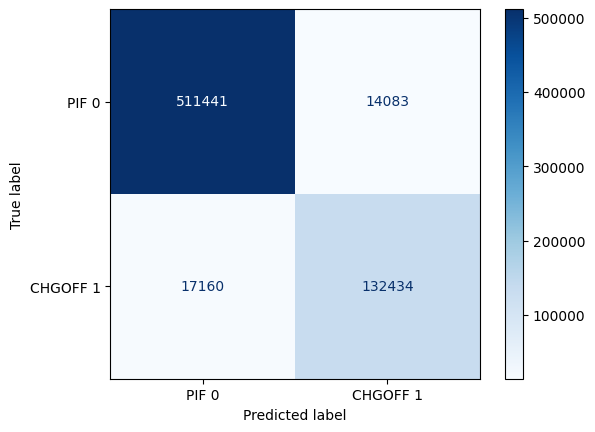

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# On crée la matrice de confusion en passant les classes et les prédictions du modèle, puis on l'affiche
cm = confusion_matrix(y_train, y_train_pred_xgb)
display(cm)

# Affichage avec un DataFrame
conf_matrix = pd.DataFrame(cm, index=["Actual PIF (0)", "Actual CHGOFF (1)"], columns=["Predicted PIF (0)", "Predicted CHGOFF (1)"])
display(conf_matrix)

# Affichage avec un plot
graph_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["PIF 0", "CHGOFF 1"])
graph_cm.plot(cmap="Blues")

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    525524
           1       0.90      0.89      0.89    149594

    accuracy                           0.95    675118
   macro avg       0.94      0.93      0.93    675118
weighted avg       0.95      0.95      0.95    675118



In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
# Au lieu d'obtenir les prédictions, on récupere les scores de probabilités pour chaque observations
y_probas_xgb = cross_val_predict(xgboost_pipeline, X_train, y_train, method="predict_proba")
display(y_probas_xgb)

# On récupere uniquement les probabilités pour la classe positive
y_scores_xgb = y_probas_xgb[:, 1]

# A partir des probabilités on calcule les combinaisons de scores pour recall et precision en fonction du seuil
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_train, y_scores_xgb)

Learning rate set to 0.151251
0:	learn: 0.5291920	total: 66.1ms	remaining: 1m 6s
1:	learn: 0.4436555	total: 126ms	remaining: 1m 3s
2:	learn: 0.3740530	total: 195ms	remaining: 1m 4s
3:	learn: 0.3391441	total: 280ms	remaining: 1m 9s
4:	learn: 0.3085494	total: 343ms	remaining: 1m 8s
5:	learn: 0.2880918	total: 410ms	remaining: 1m 7s
6:	learn: 0.2723181	total: 470ms	remaining: 1m 6s
7:	learn: 0.2611065	total: 531ms	remaining: 1m 5s
8:	learn: 0.2529182	total: 583ms	remaining: 1m 4s
9:	learn: 0.2396972	total: 644ms	remaining: 1m 3s
10:	learn: 0.2344965	total: 693ms	remaining: 1m 2s
11:	learn: 0.2246207	total: 750ms	remaining: 1m 1s
12:	learn: 0.2183558	total: 809ms	remaining: 1m 1s
13:	learn: 0.2154758	total: 864ms	remaining: 1m
14:	learn: 0.2125212	total: 918ms	remaining: 1m
15:	learn: 0.2095625	total: 972ms	remaining: 59.8s
16:	learn: 0.2066143	total: 1.03s	remaining: 59.4s
17:	learn: 0.2026688	total: 1.09s	remaining: 59.3s
18:	learn: 0.1988315	total: 1.15s	remaining: 59.3s
19:	learn: 0.196

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.151251
0:	learn: 0.5291838	total: 61.3ms	remaining: 1m 1s
1:	learn: 0.4435147	total: 114ms	remaining: 56.8s
2:	learn: 0.3715656	total: 172ms	remaining: 57s
3:	learn: 0.3316992	total: 230ms	remaining: 57.3s
4:	learn: 0.2981546	total: 288ms	remaining: 57.3s
5:	learn: 0.2799563	total: 352ms	remaining: 58.2s
6:	learn: 0.2671226	total: 409ms	remaining: 58s
7:	learn: 0.2559011	total: 459ms	remaining: 57s
8:	learn: 0.2461589	total: 515ms	remaining: 56.8s
9:	learn: 0.2359807	total: 571ms	remaining: 56.5s
10:	learn: 0.2293215	total: 635ms	remaining: 57.1s
11:	learn: 0.2244872	total: 699ms	remaining: 57.5s
12:	learn: 0.2184968	total: 762ms	remaining: 57.9s
13:	learn: 0.2138635	total: 821ms	remaining: 57.8s
14:	learn: 0.2090961	total: 879ms	remaining: 57.7s
15:	learn: 0.2054699	total: 937ms	remaining: 57.6s
16:	learn: 0.2024348	total: 994ms	remaining: 57.5s
17:	learn: 0.1998152	total: 1.05s	remaining: 57.3s
18:	learn: 0.1959273	total: 1.1s	remaining: 57s
19:	learn: 0.194096

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.151251
0:	learn: 0.5211952	total: 62.2ms	remaining: 1m 2s
1:	learn: 0.4329987	total: 117ms	remaining: 58.1s
2:	learn: 0.3708530	total: 174ms	remaining: 57.7s
3:	learn: 0.3366291	total: 229ms	remaining: 57s
4:	learn: 0.3106563	total: 281ms	remaining: 55.8s
5:	learn: 0.2811751	total: 336ms	remaining: 55.7s
6:	learn: 0.2680254	total: 390ms	remaining: 55.4s
7:	learn: 0.2589834	total: 443ms	remaining: 55s
8:	learn: 0.2478398	total: 498ms	remaining: 54.8s
9:	learn: 0.2365226	total: 559ms	remaining: 55.3s
10:	learn: 0.2273509	total: 619ms	remaining: 55.7s
11:	learn: 0.2215624	total: 680ms	remaining: 56s
12:	learn: 0.2171144	total: 729ms	remaining: 55.3s
13:	learn: 0.2124047	total: 786ms	remaining: 55.4s
14:	learn: 0.2084706	total: 843ms	remaining: 55.4s
15:	learn: 0.2049966	total: 895ms	remaining: 55s
16:	learn: 0.2025028	total: 946ms	remaining: 54.7s
17:	learn: 0.2001151	total: 1s	remaining: 54.7s
18:	learn: 0.1975707	total: 1.06s	remaining: 55s
19:	learn: 0.1956046	to

array([[9.99166013e-01, 8.33987319e-04],
       [9.71190011e-01, 2.88099892e-02],
       [9.99902126e-01, 9.78738822e-05],
       ...,
       [9.98463274e-01, 1.53672637e-03],
       [6.28062982e-03, 9.93719370e-01],
       [9.27280940e-01, 7.27190599e-02]])

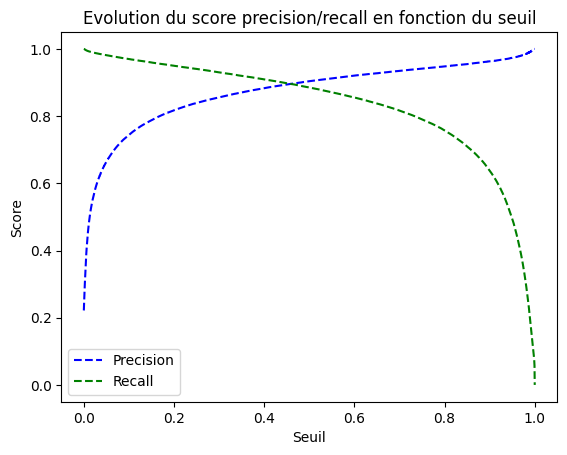

In [15]:
import matplotlib.pyplot as plt

plt.plot(thresholds_xgb, precisions_xgb[:-1], "b--", label="Precision")
plt.plot(thresholds_xgb, recalls_xgb[:-1], "g--", label="Recall")
plt.title("Evolution du score precision/recall en fonction du seuil")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import roc_curve

# La fonction roc_curve retourne le FPR, TPR et les seuils 
fpr_xgb, tpr_xgb, tresholds_xgb = roc_curve(y_train, y_scores_xgb)

In [17]:
# Fonction pour représenter la courbe ROC
def plot_roc_curve(fpr, tpr, label=None):

    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("Courbe ROC")
    plt.xlabel("Taux de Faux Positif")
    plt.ylabel("Taux de Vrai Positif")
    plt.grid()

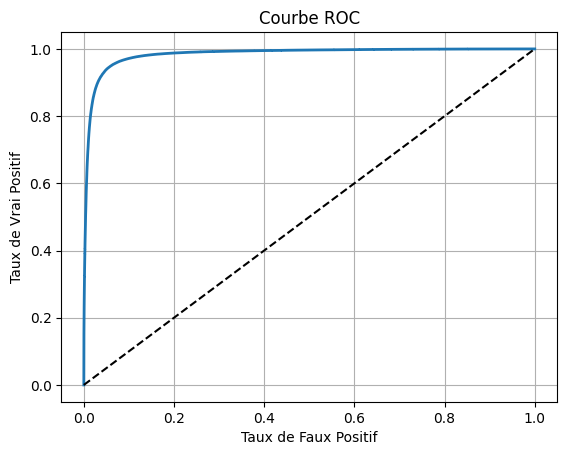

In [18]:
plot_roc_curve(fpr_xgb, tpr_xgb)
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score

display(roc_auc_score(y_train, y_scores_xgb))

0.9839163812114109

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


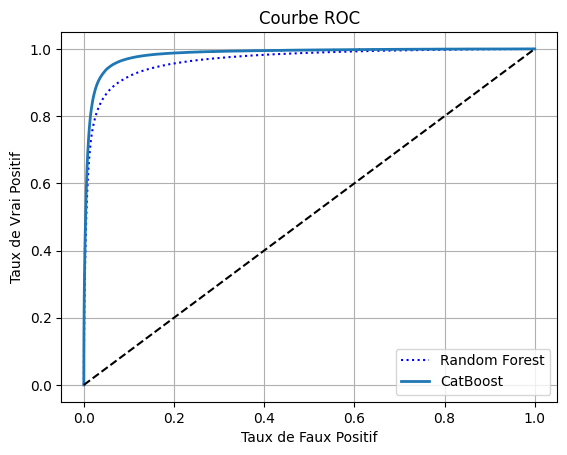

AUC modèle XGBOOST 0.9839163812114109
AUC modèle Random Forest 0.9661637929955241


In [20]:
# On récupere les scores pour le modèle random forest
y_probas_rf = cross_val_predict(rf_pipeline, X_train, y_train, method="predict_proba")
y_scores_rf = y_probas_rf[:, 1]

# On calcule le TPR et FPR pour le modèle random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf)

# On représente graphiquement les deux modèles
plt.plot(fpr_rf, tpr_rf, "b:", label="Random Forest")
plot_roc_curve(fpr_xgb, tpr_xgb, "CatBoost")
plt.legend(loc="lower right")
plt.show()

print("AUC modèle XGBOOST", roc_auc_score(y_train, y_scores_xgb))
print("AUC modèle Random Forest", roc_auc_score(y_train, y_scores_rf))

Learning rate set to 0.056584
0:	learn: 0.6301250	total: 31.1ms	remaining: 31.1s
1:	learn: 0.5784383	total: 61.7ms	remaining: 30.8s
2:	learn: 0.5357262	total: 86.2ms	remaining: 28.6s
3:	learn: 0.4961950	total: 110ms	remaining: 27.3s
4:	learn: 0.4630009	total: 134ms	remaining: 26.7s
5:	learn: 0.4384890	total: 158ms	remaining: 26.2s
6:	learn: 0.4129395	total: 183ms	remaining: 26s
7:	learn: 0.3903696	total: 209ms	remaining: 25.9s
8:	learn: 0.3746323	total: 235ms	remaining: 25.8s
9:	learn: 0.3613049	total: 261ms	remaining: 25.8s
10:	learn: 0.3448461	total: 289ms	remaining: 26s
11:	learn: 0.3331893	total: 317ms	remaining: 26.1s
12:	learn: 0.3232763	total: 346ms	remaining: 26.3s
13:	learn: 0.3153685	total: 373ms	remaining: 26.3s
14:	learn: 0.3079078	total: 394ms	remaining: 25.9s
15:	learn: 0.3003895	total: 415ms	remaining: 25.5s
16:	learn: 0.2950679	total: 436ms	remaining: 25.2s
17:	learn: 0.2898584	total: 457ms	remaining: 24.9s
18:	learn: 0.2853160	total: 477ms	remaining: 24.6s
19:	learn: 0

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.076074
0:	learn: 0.6077486	total: 31.7ms	remaining: 31.6s
1:	learn: 0.5376553	total: 58.3ms	remaining: 29.1s
2:	learn: 0.4855321	total: 84.3ms	remaining: 28s
3:	learn: 0.4465285	total: 111ms	remaining: 27.6s
4:	learn: 0.4170338	total: 136ms	remaining: 27s
5:	learn: 0.3885388	total: 162ms	remaining: 26.8s
6:	learn: 0.3642992	total: 186ms	remaining: 26.4s
7:	learn: 0.3425352	total: 211ms	remaining: 26.2s
8:	learn: 0.3305067	total: 235ms	remaining: 25.8s
9:	learn: 0.3195740	total: 255ms	remaining: 25.3s
10:	learn: 0.3072588	total: 280ms	remaining: 25.2s
11:	learn: 0.2978337	total: 304ms	remaining: 25s
12:	learn: 0.2882439	total: 330ms	remaining: 25.1s
13:	learn: 0.2789301	total: 354ms	remaining: 24.9s
14:	learn: 0.2707682	total: 378ms	remaining: 24.8s
15:	learn: 0.2646404	total: 402ms	remaining: 24.7s
16:	learn: 0.2593780	total: 426ms	remaining: 24.6s
17:	learn: 0.2545671	total: 450ms	remaining: 24.5s
18:	learn: 0.2489588	total: 475ms	remaining: 24.5s
19:	learn: 0.2

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.090454
0:	learn: 0.5922425	total: 32.9ms	remaining: 32.8s
1:	learn: 0.5134787	total: 65.6ms	remaining: 32.7s
2:	learn: 0.4576254	total: 96.9ms	remaining: 32.2s
3:	learn: 0.4143859	total: 127ms	remaining: 31.7s
4:	learn: 0.3805251	total: 158ms	remaining: 31.5s
5:	learn: 0.3519679	total: 189ms	remaining: 31.3s
6:	learn: 0.3352431	total: 220ms	remaining: 31.2s
7:	learn: 0.3210251	total: 250ms	remaining: 31s
8:	learn: 0.3078017	total: 277ms	remaining: 30.5s
9:	learn: 0.2928961	total: 305ms	remaining: 30.2s
10:	learn: 0.2807863	total: 335ms	remaining: 30.1s
11:	learn: 0.2727837	total: 364ms	remaining: 29.9s
12:	learn: 0.2656803	total: 393ms	remaining: 29.8s
13:	learn: 0.2588294	total: 423ms	remaining: 29.8s
14:	learn: 0.2527260	total: 452ms	remaining: 29.6s
15:	learn: 0.2478628	total: 480ms	remaining: 29.5s
16:	learn: 0.2434079	total: 506ms	remaining: 29.3s
17:	learn: 0.2393531	total: 535ms	remaining: 29.2s
18:	learn: 0.2366754	total: 563ms	remaining: 29.1s
19:	learn:

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.102277
0:	learn: 0.5722635	total: 43ms	remaining: 42.9s
1:	learn: 0.4896193	total: 79.6ms	remaining: 39.7s
2:	learn: 0.4327702	total: 113ms	remaining: 37.5s
3:	learn: 0.3901963	total: 154ms	remaining: 38.2s
4:	learn: 0.3553478	total: 190ms	remaining: 37.8s
5:	learn: 0.3347840	total: 228ms	remaining: 37.8s
6:	learn: 0.3171094	total: 263ms	remaining: 37.4s
7:	learn: 0.3020620	total: 294ms	remaining: 36.4s
8:	learn: 0.2903813	total: 328ms	remaining: 36.1s
9:	learn: 0.2816076	total: 360ms	remaining: 35.6s
10:	learn: 0.2722072	total: 395ms	remaining: 35.5s
11:	learn: 0.2616755	total: 431ms	remaining: 35.5s
12:	learn: 0.2563644	total: 463ms	remaining: 35.1s
13:	learn: 0.2492278	total: 498ms	remaining: 35s
14:	learn: 0.2404421	total: 532ms	remaining: 35s
15:	learn: 0.2347811	total: 566ms	remaining: 34.8s
16:	learn: 0.2313897	total: 599ms	remaining: 34.6s
17:	learn: 0.2287371	total: 629ms	remaining: 34.3s
18:	learn: 0.2234910	total: 665ms	remaining: 34.3s
19:	learn: 0.22

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.112502
0:	learn: 0.5608149	total: 44.9ms	remaining: 44.9s
1:	learn: 0.4764084	total: 87.2ms	remaining: 43.5s
2:	learn: 0.4210359	total: 124ms	remaining: 41.3s
3:	learn: 0.3819241	total: 163ms	remaining: 40.7s
4:	learn: 0.3525942	total: 198ms	remaining: 39.4s
5:	learn: 0.3252815	total: 236ms	remaining: 39.1s
6:	learn: 0.3010646	total: 279ms	remaining: 39.5s
7:	learn: 0.2845079	total: 317ms	remaining: 39.3s
8:	learn: 0.2741046	total: 354ms	remaining: 39s
9:	learn: 0.2658688	total: 390ms	remaining: 38.6s
10:	learn: 0.2543981	total: 428ms	remaining: 38.5s
11:	learn: 0.2486964	total: 479ms	remaining: 39.5s
12:	learn: 0.2413337	total: 523ms	remaining: 39.7s
13:	learn: 0.2346862	total: 563ms	remaining: 39.6s
14:	learn: 0.2300474	total: 603ms	remaining: 39.6s
15:	learn: 0.2267421	total: 637ms	remaining: 39.2s
16:	learn: 0.2225716	total: 676ms	remaining: 39.1s
17:	learn: 0.2196128	total: 708ms	remaining: 38.6s
18:	learn: 0.2171533	total: 740ms	remaining: 38.2s
19:	learn: 

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.12161
0:	learn: 0.5516692	total: 44.4ms	remaining: 44.4s
1:	learn: 0.4750047	total: 81.2ms	remaining: 40.5s
2:	learn: 0.4112632	total: 124ms	remaining: 41.1s
3:	learn: 0.3697177	total: 160ms	remaining: 39.9s
4:	learn: 0.3337498	total: 198ms	remaining: 39.5s
5:	learn: 0.3097931	total: 237ms	remaining: 39.3s
6:	learn: 0.2955644	total: 276ms	remaining: 39.2s
7:	learn: 0.2832714	total: 312ms	remaining: 38.7s
8:	learn: 0.2670840	total: 351ms	remaining: 38.7s
9:	learn: 0.2596836	total: 385ms	remaining: 38.1s
10:	learn: 0.2522039	total: 427ms	remaining: 38.4s
11:	learn: 0.2426798	total: 466ms	remaining: 38.4s
12:	learn: 0.2357939	total: 505ms	remaining: 38.4s
13:	learn: 0.2295749	total: 545ms	remaining: 38.4s
14:	learn: 0.2253351	total: 585ms	remaining: 38.4s
15:	learn: 0.2213699	total: 620ms	remaining: 38.1s
16:	learn: 0.2166800	total: 660ms	remaining: 38.2s
17:	learn: 0.2131919	total: 701ms	remaining: 38.2s
18:	learn: 0.2104236	total: 736ms	remaining: 38s
19:	learn: 0

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.129884
0:	learn: 0.5431866	total: 49.5ms	remaining: 49.5s
1:	learn: 0.4639923	total: 90.4ms	remaining: 45.1s
2:	learn: 0.3996606	total: 137ms	remaining: 45.5s
3:	learn: 0.3586171	total: 178ms	remaining: 44.4s
4:	learn: 0.3215665	total: 229ms	remaining: 45.5s
5:	learn: 0.3027563	total: 272ms	remaining: 45s
6:	learn: 0.2874982	total: 311ms	remaining: 44.1s
7:	learn: 0.2753669	total: 354ms	remaining: 43.9s
8:	learn: 0.2626347	total: 405ms	remaining: 44.6s
9:	learn: 0.2557287	total: 445ms	remaining: 44.1s
10:	learn: 0.2458002	total: 491ms	remaining: 44.1s
11:	learn: 0.2357984	total: 537ms	remaining: 44.2s
12:	learn: 0.2306332	total: 579ms	remaining: 43.9s
13:	learn: 0.2234111	total: 626ms	remaining: 44.1s
14:	learn: 0.2185199	total: 673ms	remaining: 44.2s
15:	learn: 0.2155501	total: 712ms	remaining: 43.8s
16:	learn: 0.2122960	total: 759ms	remaining: 43.9s
17:	learn: 0.2097901	total: 804ms	remaining: 43.9s
18:	learn: 0.2062232	total: 848ms	remaining: 43.8s
19:	learn: 

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.137505
0:	learn: 0.5352700	total: 52.6ms	remaining: 52.5s
1:	learn: 0.4501667	total: 97.6ms	remaining: 48.7s
2:	learn: 0.3891884	total: 153ms	remaining: 50.8s
3:	learn: 0.3463822	total: 207ms	remaining: 51.6s
4:	learn: 0.3218784	total: 260ms	remaining: 51.7s
5:	learn: 0.2926315	total: 319ms	remaining: 52.9s
6:	learn: 0.2772239	total: 380ms	remaining: 53.9s
7:	learn: 0.2667336	total: 437ms	remaining: 54.2s
8:	learn: 0.2543843	total: 503ms	remaining: 55.4s
9:	learn: 0.2466282	total: 559ms	remaining: 55.3s
10:	learn: 0.2411361	total: 614ms	remaining: 55.2s
11:	learn: 0.2345039	total: 667ms	remaining: 54.9s
12:	learn: 0.2262318	total: 719ms	remaining: 54.6s
13:	learn: 0.2215193	total: 766ms	remaining: 54s
14:	learn: 0.2172313	total: 816ms	remaining: 53.6s
15:	learn: 0.2122762	total: 863ms	remaining: 53.1s
16:	learn: 0.2085340	total: 910ms	remaining: 52.6s
17:	learn: 0.2063297	total: 956ms	remaining: 52.2s
18:	learn: 0.2023766	total: 1s	remaining: 51.8s
19:	learn: 0.2

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.144597
0:	learn: 0.5284780	total: 68.3ms	remaining: 1m 8s
1:	learn: 0.4463493	total: 122ms	remaining: 1m
2:	learn: 0.3778644	total: 184ms	remaining: 1m 1s
3:	learn: 0.3364141	total: 240ms	remaining: 59.8s
4:	learn: 0.3128858	total: 293ms	remaining: 58.4s
5:	learn: 0.2923880	total: 350ms	remaining: 58s
6:	learn: 0.2772208	total: 412ms	remaining: 58.4s
7:	learn: 0.2631626	total: 470ms	remaining: 58.3s
8:	learn: 0.2531221	total: 527ms	remaining: 58s
9:	learn: 0.2438050	total: 586ms	remaining: 58s
10:	learn: 0.2365090	total: 644ms	remaining: 57.9s
11:	learn: 0.2261120	total: 704ms	remaining: 57.9s
12:	learn: 0.2212627	total: 761ms	remaining: 57.8s
13:	learn: 0.2165385	total: 818ms	remaining: 57.6s
14:	learn: 0.2126516	total: 877ms	remaining: 57.6s
15:	learn: 0.2097418	total: 931ms	remaining: 57.3s
16:	learn: 0.2071775	total: 978ms	remaining: 56.5s
17:	learn: 0.2020296	total: 1.03s	remaining: 56.3s
18:	learn: 0.2000044	total: 1.09s	remaining: 56.1s
19:	learn: 0.197997

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.151251
0:	learn: 0.5291920	total: 63.9ms	remaining: 1m 3s
1:	learn: 0.4436555	total: 120ms	remaining: 59.8s
2:	learn: 0.3740530	total: 186ms	remaining: 1m 1s
3:	learn: 0.3391441	total: 240ms	remaining: 59.7s
4:	learn: 0.3085494	total: 294ms	remaining: 58.4s
5:	learn: 0.2880918	total: 350ms	remaining: 58s
6:	learn: 0.2723181	total: 402ms	remaining: 57s
7:	learn: 0.2611065	total: 456ms	remaining: 56.6s
8:	learn: 0.2529182	total: 505ms	remaining: 55.6s
9:	learn: 0.2396972	total: 560ms	remaining: 55.5s
10:	learn: 0.2344965	total: 608ms	remaining: 54.6s
11:	learn: 0.2246207	total: 664ms	remaining: 54.7s
12:	learn: 0.2183558	total: 719ms	remaining: 54.6s
13:	learn: 0.2154758	total: 771ms	remaining: 54.3s
14:	learn: 0.2125212	total: 825ms	remaining: 54.2s
15:	learn: 0.2095625	total: 878ms	remaining: 54s
16:	learn: 0.2066143	total: 932ms	remaining: 53.9s
17:	learn: 0.2026688	total: 989ms	remaining: 53.9s
18:	learn: 0.1988315	total: 1.05s	remaining: 54.1s
19:	learn: 0.196

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.056584
0:	learn: 0.6308200	total: 40ms	remaining: 40s
1:	learn: 0.5778548	total: 81.5ms	remaining: 40.7s
2:	learn: 0.5353092	total: 123ms	remaining: 40.8s
3:	learn: 0.4941381	total: 168ms	remaining: 41.8s
4:	learn: 0.4639378	total: 211ms	remaining: 41.9s
5:	learn: 0.4375842	total: 257ms	remaining: 42.6s
6:	learn: 0.4106906	total: 297ms	remaining: 42.1s
7:	learn: 0.3913149	total: 337ms	remaining: 41.8s
8:	learn: 0.3767342	total: 375ms	remaining: 41.3s
9:	learn: 0.3624121	total: 412ms	remaining: 40.8s
10:	learn: 0.3492757	total: 440ms	remaining: 39.6s
11:	learn: 0.3359450	total: 466ms	remaining: 38.4s
12:	learn: 0.3247478	total: 490ms	remaining: 37.2s
13:	learn: 0.3168172	total: 516ms	remaining: 36.3s
14:	learn: 0.3098851	total: 541ms	remaining: 35.5s
15:	learn: 0.3013367	total: 566ms	remaining: 34.8s
16:	learn: 0.2949868	total: 591ms	remaining: 34.1s
17:	learn: 0.2884577	total: 615ms	remaining: 33.6s
18:	learn: 0.2827684	total: 642ms	remaining: 33.1s
19:	learn: 0.

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.076074
0:	learn: 0.6098846	total: 28ms	remaining: 27.9s
1:	learn: 0.5430539	total: 54.5ms	remaining: 27.2s
2:	learn: 0.4868257	total: 82.8ms	remaining: 27.5s
3:	learn: 0.4485138	total: 108ms	remaining: 27s
4:	learn: 0.4138471	total: 134ms	remaining: 26.7s
5:	learn: 0.3859194	total: 160ms	remaining: 26.5s
6:	learn: 0.3661054	total: 185ms	remaining: 26.2s
7:	learn: 0.3501941	total: 210ms	remaining: 26.1s
8:	learn: 0.3345331	total: 236ms	remaining: 26s
9:	learn: 0.3151054	total: 262ms	remaining: 26s
10:	learn: 0.3050654	total: 287ms	remaining: 25.8s
11:	learn: 0.2960387	total: 313ms	remaining: 25.8s
12:	learn: 0.2863728	total: 340ms	remaining: 25.8s
13:	learn: 0.2773017	total: 367ms	remaining: 25.8s
14:	learn: 0.2696132	total: 392ms	remaining: 25.8s
15:	learn: 0.2618869	total: 417ms	remaining: 25.7s
16:	learn: 0.2575052	total: 442ms	remaining: 25.5s
17:	learn: 0.2518307	total: 467ms	remaining: 25.5s
18:	learn: 0.2472696	total: 492ms	remaining: 25.4s
19:	learn: 0.243

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.090454
0:	learn: 0.5904183	total: 46.2ms	remaining: 46.1s
1:	learn: 0.5180563	total: 80.5ms	remaining: 40.1s
2:	learn: 0.4569415	total: 114ms	remaining: 37.9s
3:	learn: 0.4177352	total: 151ms	remaining: 37.5s
4:	learn: 0.3832148	total: 184ms	remaining: 36.7s
5:	learn: 0.3545439	total: 218ms	remaining: 36.1s
6:	learn: 0.3367922	total: 253ms	remaining: 35.9s
7:	learn: 0.3221771	total: 287ms	remaining: 35.6s
8:	learn: 0.3085119	total: 320ms	remaining: 35.2s
9:	learn: 0.2968332	total: 355ms	remaining: 35.2s
10:	learn: 0.2867654	total: 388ms	remaining: 34.9s
11:	learn: 0.2737026	total: 423ms	remaining: 34.8s
12:	learn: 0.2666107	total: 453ms	remaining: 34.4s
13:	learn: 0.2608852	total: 482ms	remaining: 33.9s
14:	learn: 0.2524924	total: 515ms	remaining: 33.8s
15:	learn: 0.2467117	total: 546ms	remaining: 33.6s
16:	learn: 0.2396778	total: 578ms	remaining: 33.5s
17:	learn: 0.2359520	total: 608ms	remaining: 33.2s
18:	learn: 0.2322456	total: 639ms	remaining: 33s
19:	learn: 

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.102277
0:	learn: 0.5710330	total: 39.5ms	remaining: 39.4s
1:	learn: 0.4929014	total: 77.8ms	remaining: 38.8s
2:	learn: 0.4411199	total: 112ms	remaining: 37.2s
3:	learn: 0.3940447	total: 152ms	remaining: 37.8s
4:	learn: 0.3649029	total: 186ms	remaining: 37s
5:	learn: 0.3359416	total: 226ms	remaining: 37.4s
6:	learn: 0.3169863	total: 258ms	remaining: 36.6s
7:	learn: 0.3028499	total: 301ms	remaining: 37.3s
8:	learn: 0.2855893	total: 335ms	remaining: 36.9s
9:	learn: 0.2764234	total: 367ms	remaining: 36.3s
10:	learn: 0.2671380	total: 400ms	remaining: 36s
11:	learn: 0.2563288	total: 434ms	remaining: 35.7s
12:	learn: 0.2481047	total: 470ms	remaining: 35.7s
13:	learn: 0.2423820	total: 502ms	remaining: 35.4s
14:	learn: 0.2359540	total: 535ms	remaining: 35.1s
15:	learn: 0.2319840	total: 565ms	remaining: 34.8s
16:	learn: 0.2274971	total: 597ms	remaining: 34.5s
17:	learn: 0.2231776	total: 631ms	remaining: 34.4s
18:	learn: 0.2189931	total: 665ms	remaining: 34.3s
19:	learn: 0.

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.112502
0:	learn: 0.5656804	total: 41.9ms	remaining: 41.9s
1:	learn: 0.4927654	total: 79.8ms	remaining: 39.8s
2:	learn: 0.4244466	total: 119ms	remaining: 39.5s
3:	learn: 0.3815514	total: 165ms	remaining: 41s
4:	learn: 0.3468102	total: 202ms	remaining: 40.3s
5:	learn: 0.3272843	total: 240ms	remaining: 39.7s
6:	learn: 0.3093323	total: 276ms	remaining: 39.1s
7:	learn: 0.2947415	total: 312ms	remaining: 38.7s
8:	learn: 0.2819276	total: 350ms	remaining: 38.6s
9:	learn: 0.2659413	total: 390ms	remaining: 38.6s
10:	learn: 0.2558142	total: 431ms	remaining: 38.7s
11:	learn: 0.2488785	total: 468ms	remaining: 38.5s
12:	learn: 0.2435539	total: 500ms	remaining: 38s
13:	learn: 0.2350777	total: 536ms	remaining: 37.7s
14:	learn: 0.2295258	total: 573ms	remaining: 37.6s
15:	learn: 0.2239932	total: 609ms	remaining: 37.5s
16:	learn: 0.2207396	total: 645ms	remaining: 37.3s
17:	learn: 0.2164541	total: 679ms	remaining: 37s
18:	learn: 0.2142783	total: 715ms	remaining: 36.9s
19:	learn: 0.21

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.12161
0:	learn: 0.5571569	total: 46.3ms	remaining: 46.3s
1:	learn: 0.4811955	total: 86.5ms	remaining: 43.1s
2:	learn: 0.4120205	total: 130ms	remaining: 43.3s
3:	learn: 0.3689875	total: 176ms	remaining: 43.8s
4:	learn: 0.3390593	total: 216ms	remaining: 43.1s
5:	learn: 0.3132194	total: 261ms	remaining: 43.2s
6:	learn: 0.2919108	total: 304ms	remaining: 43.1s
7:	learn: 0.2799266	total: 343ms	remaining: 42.5s
8:	learn: 0.2644141	total: 381ms	remaining: 42s
9:	learn: 0.2546885	total: 421ms	remaining: 41.7s
10:	learn: 0.2479839	total: 463ms	remaining: 41.6s
11:	learn: 0.2417722	total: 505ms	remaining: 41.5s
12:	learn: 0.2354535	total: 548ms	remaining: 41.6s
13:	learn: 0.2308881	total: 585ms	remaining: 41.2s
14:	learn: 0.2268247	total: 623ms	remaining: 40.9s
15:	learn: 0.2231086	total: 663ms	remaining: 40.8s
16:	learn: 0.2197162	total: 702ms	remaining: 40.6s
17:	learn: 0.2151088	total: 746ms	remaining: 40.7s
18:	learn: 0.2121068	total: 791ms	remaining: 40.8s
19:	learn: 0

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.129884
0:	learn: 0.5421382	total: 51.6ms	remaining: 51.6s
1:	learn: 0.4591981	total: 97.2ms	remaining: 48.5s
2:	learn: 0.3983471	total: 143ms	remaining: 47.6s
3:	learn: 0.3593492	total: 187ms	remaining: 46.6s
4:	learn: 0.3271766	total: 232ms	remaining: 46.2s
5:	learn: 0.3086388	total: 272ms	remaining: 45.1s
6:	learn: 0.2895809	total: 315ms	remaining: 44.7s
7:	learn: 0.2784181	total: 355ms	remaining: 44.1s
8:	learn: 0.2637478	total: 399ms	remaining: 43.9s
9:	learn: 0.2490918	total: 445ms	remaining: 44s
10:	learn: 0.2422448	total: 486ms	remaining: 43.7s
11:	learn: 0.2349041	total: 526ms	remaining: 43.3s
12:	learn: 0.2279807	total: 570ms	remaining: 43.2s
13:	learn: 0.2234238	total: 614ms	remaining: 43.2s
14:	learn: 0.2192376	total: 652ms	remaining: 42.8s
15:	learn: 0.2161008	total: 694ms	remaining: 42.7s
16:	learn: 0.2110731	total: 739ms	remaining: 42.7s
17:	learn: 0.2078478	total: 790ms	remaining: 43.1s
18:	learn: 0.2056088	total: 841ms	remaining: 43.4s
19:	learn: 

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.137505
0:	learn: 0.5391219	total: 55.3ms	remaining: 55.2s
1:	learn: 0.4542572	total: 100ms	remaining: 50.1s
2:	learn: 0.3882564	total: 149ms	remaining: 49.7s
3:	learn: 0.3482146	total: 197ms	remaining: 49s
4:	learn: 0.3118352	total: 245ms	remaining: 48.8s
5:	learn: 0.2935340	total: 287ms	remaining: 47.5s
6:	learn: 0.2789332	total: 335ms	remaining: 47.5s
7:	learn: 0.2628558	total: 382ms	remaining: 47.4s
8:	learn: 0.2553787	total: 429ms	remaining: 47.2s
9:	learn: 0.2457845	total: 479ms	remaining: 47.4s
10:	learn: 0.2355739	total: 525ms	remaining: 47.2s
11:	learn: 0.2296601	total: 567ms	remaining: 46.7s
12:	learn: 0.2250824	total: 608ms	remaining: 46.1s
13:	learn: 0.2207147	total: 657ms	remaining: 46.3s
14:	learn: 0.2174348	total: 701ms	remaining: 46s
15:	learn: 0.2129803	total: 752ms	remaining: 46.2s
16:	learn: 0.2076983	total: 801ms	remaining: 46.3s
17:	learn: 0.2051975	total: 848ms	remaining: 46.3s
18:	learn: 0.2018525	total: 898ms	remaining: 46.4s
19:	learn: 0.2

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.144597
0:	learn: 0.5350272	total: 57ms	remaining: 57s
1:	learn: 0.4509111	total: 104ms	remaining: 51.8s
2:	learn: 0.3842258	total: 156ms	remaining: 51.8s
3:	learn: 0.3384861	total: 208ms	remaining: 51.9s
4:	learn: 0.3134725	total: 255ms	remaining: 50.7s
5:	learn: 0.2876301	total: 307ms	remaining: 50.9s
6:	learn: 0.2742098	total: 354ms	remaining: 50.3s
7:	learn: 0.2649629	total: 401ms	remaining: 49.7s
8:	learn: 0.2520241	total: 457ms	remaining: 50.3s
9:	learn: 0.2416123	total: 509ms	remaining: 50.3s
10:	learn: 0.2316147	total: 563ms	remaining: 50.6s
11:	learn: 0.2260625	total: 616ms	remaining: 50.7s
12:	learn: 0.2199224	total: 672ms	remaining: 51s
13:	learn: 0.2153503	total: 729ms	remaining: 51.4s
14:	learn: 0.2120526	total: 777ms	remaining: 51.1s
15:	learn: 0.2096469	total: 830ms	remaining: 51s
16:	learn: 0.2071565	total: 881ms	remaining: 51s
17:	learn: 0.2029232	total: 933ms	remaining: 50.9s
18:	learn: 0.2004059	total: 984ms	remaining: 50.8s
19:	learn: 0.1985006

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.151251
0:	learn: 0.5288041	total: 61.2ms	remaining: 1m 1s
1:	learn: 0.4432339	total: 114ms	remaining: 56.8s
2:	learn: 0.3800197	total: 172ms	remaining: 57.1s
3:	learn: 0.3437637	total: 224ms	remaining: 55.7s
4:	learn: 0.3039692	total: 278ms	remaining: 55.4s
5:	learn: 0.2869346	total: 327ms	remaining: 54.2s
6:	learn: 0.2736478	total: 382ms	remaining: 54.2s
7:	learn: 0.2618622	total: 435ms	remaining: 53.9s
8:	learn: 0.2477972	total: 489ms	remaining: 53.8s
9:	learn: 0.2408700	total: 543ms	remaining: 53.7s
10:	learn: 0.2350808	total: 598ms	remaining: 53.8s
11:	learn: 0.2258082	total: 656ms	remaining: 54s
12:	learn: 0.2199459	total: 714ms	remaining: 54.2s
13:	learn: 0.2139345	total: 770ms	remaining: 54.3s
14:	learn: 0.2108328	total: 819ms	remaining: 53.8s
15:	learn: 0.2076769	total: 877ms	remaining: 53.9s
16:	learn: 0.2048404	total: 933ms	remaining: 53.9s
17:	learn: 0.2029813	total: 988ms	remaining: 53.9s
18:	learn: 0.1994745	total: 1.04s	remaining: 53.9s
19:	learn: 0

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.056584
0:	learn: 0.6308200	total: 42.6ms	remaining: 42.6s
1:	learn: 0.5778548	total: 85ms	remaining: 42.4s
2:	learn: 0.5353092	total: 127ms	remaining: 42.4s
3:	learn: 0.4941381	total: 170ms	remaining: 42.4s
4:	learn: 0.4639378	total: 199ms	remaining: 39.7s
5:	learn: 0.4375842	total: 221ms	remaining: 36.6s
6:	learn: 0.4106906	total: 244ms	remaining: 34.6s
7:	learn: 0.3913149	total: 267ms	remaining: 33.1s
8:	learn: 0.3767342	total: 288ms	remaining: 31.7s
9:	learn: 0.3624121	total: 310ms	remaining: 30.7s
10:	learn: 0.3492757	total: 332ms	remaining: 29.9s
11:	learn: 0.3359450	total: 354ms	remaining: 29.1s
12:	learn: 0.3247478	total: 375ms	remaining: 28.5s
13:	learn: 0.3168172	total: 396ms	remaining: 27.9s
14:	learn: 0.3098851	total: 417ms	remaining: 27.4s
15:	learn: 0.3013367	total: 440ms	remaining: 27s
16:	learn: 0.2949868	total: 462ms	remaining: 26.7s
17:	learn: 0.2884577	total: 483ms	remaining: 26.4s
18:	learn: 0.2827684	total: 504ms	remaining: 26s
19:	learn: 0.27

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.076074
0:	learn: 0.6098846	total: 31.5ms	remaining: 31.5s
1:	learn: 0.5430539	total: 62ms	remaining: 30.9s
2:	learn: 0.4868257	total: 102ms	remaining: 34s
3:	learn: 0.4485138	total: 145ms	remaining: 36s
4:	learn: 0.4138471	total: 178ms	remaining: 35.4s
5:	learn: 0.3859194	total: 209ms	remaining: 34.6s
6:	learn: 0.3661054	total: 236ms	remaining: 33.5s
7:	learn: 0.3501941	total: 264ms	remaining: 32.8s
8:	learn: 0.3345331	total: 292ms	remaining: 32.1s
9:	learn: 0.3151054	total: 319ms	remaining: 31.6s
10:	learn: 0.3050654	total: 346ms	remaining: 31.1s
11:	learn: 0.2960387	total: 377ms	remaining: 31.1s
12:	learn: 0.2863728	total: 406ms	remaining: 30.8s
13:	learn: 0.2773017	total: 435ms	remaining: 30.6s
14:	learn: 0.2696132	total: 462ms	remaining: 30.4s
15:	learn: 0.2618869	total: 488ms	remaining: 30s
16:	learn: 0.2575052	total: 514ms	remaining: 29.7s
17:	learn: 0.2518307	total: 541ms	remaining: 29.5s
18:	learn: 0.2472696	total: 567ms	remaining: 29.3s
19:	learn: 0.2433

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.090454
0:	learn: 0.5904183	total: 35.2ms	remaining: 35.1s
1:	learn: 0.5180563	total: 70.9ms	remaining: 35.4s
2:	learn: 0.4569415	total: 108ms	remaining: 35.9s
3:	learn: 0.4177352	total: 145ms	remaining: 36.1s
4:	learn: 0.3832148	total: 179ms	remaining: 35.6s
5:	learn: 0.3545439	total: 215ms	remaining: 35.6s
6:	learn: 0.3367922	total: 256ms	remaining: 36.3s
7:	learn: 0.3221771	total: 292ms	remaining: 36.1s
8:	learn: 0.3085119	total: 323ms	remaining: 35.6s
9:	learn: 0.2968332	total: 354ms	remaining: 35s
10:	learn: 0.2867654	total: 387ms	remaining: 34.8s
11:	learn: 0.2737026	total: 422ms	remaining: 34.7s
12:	learn: 0.2666107	total: 460ms	remaining: 34.9s
13:	learn: 0.2608852	total: 492ms	remaining: 34.6s
14:	learn: 0.2524924	total: 528ms	remaining: 34.7s
15:	learn: 0.2467117	total: 563ms	remaining: 34.6s
16:	learn: 0.2396778	total: 600ms	remaining: 34.7s
17:	learn: 0.2359520	total: 634ms	remaining: 34.6s
18:	learn: 0.2322456	total: 667ms	remaining: 34.4s
19:	learn: 

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.102277
0:	learn: 0.5710330	total: 36.9ms	remaining: 36.9s
1:	learn: 0.4929014	total: 73.2ms	remaining: 36.5s
2:	learn: 0.4411199	total: 107ms	remaining: 35.4s
3:	learn: 0.3940447	total: 144ms	remaining: 35.8s
4:	learn: 0.3649029	total: 174ms	remaining: 34.7s
5:	learn: 0.3359416	total: 211ms	remaining: 35s
6:	learn: 0.3169863	total: 240ms	remaining: 34s
7:	learn: 0.3028499	total: 271ms	remaining: 33.6s
8:	learn: 0.2855893	total: 305ms	remaining: 33.6s
9:	learn: 0.2764234	total: 338ms	remaining: 33.5s
10:	learn: 0.2671380	total: 371ms	remaining: 33.3s
11:	learn: 0.2563288	total: 405ms	remaining: 33.3s
12:	learn: 0.2481047	total: 440ms	remaining: 33.4s
13:	learn: 0.2423820	total: 473ms	remaining: 33.3s
14:	learn: 0.2359540	total: 506ms	remaining: 33.2s
15:	learn: 0.2319840	total: 537ms	remaining: 33s
16:	learn: 0.2274971	total: 569ms	remaining: 32.9s
17:	learn: 0.2231776	total: 603ms	remaining: 32.9s
18:	learn: 0.2189931	total: 640ms	remaining: 33.1s
19:	learn: 0.21

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.112502
0:	learn: 0.5660524	total: 42.5ms	remaining: 42.5s
1:	learn: 0.4935068	total: 78.2ms	remaining: 39s
2:	learn: 0.4252801	total: 117ms	remaining: 39s
3:	learn: 0.3824454	total: 158ms	remaining: 39.2s
4:	learn: 0.3477017	total: 198ms	remaining: 39.3s
5:	learn: 0.3281887	total: 237ms	remaining: 39.3s
6:	learn: 0.3102524	total: 276ms	remaining: 39.2s
7:	learn: 0.2956649	total: 319ms	remaining: 39.6s
8:	learn: 0.2828347	total: 360ms	remaining: 39.7s
9:	learn: 0.2668059	total: 403ms	remaining: 39.9s
10:	learn: 0.2566474	total: 445ms	remaining: 40s
11:	learn: 0.2496951	total: 484ms	remaining: 39.8s
12:	learn: 0.2429981	total: 526ms	remaining: 39.9s
13:	learn: 0.2381579	total: 565ms	remaining: 39.8s
14:	learn: 0.2320343	total: 611ms	remaining: 40.1s
15:	learn: 0.2260871	total: 656ms	remaining: 40.4s
16:	learn: 0.2229592	total: 699ms	remaining: 40.4s
17:	learn: 0.2185818	total: 743ms	remaining: 40.5s
18:	learn: 0.2159995	total: 779ms	remaining: 40.2s
19:	learn: 0.21

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.12161
0:	learn: 0.5571405	total: 44.2ms	remaining: 44.2s
1:	learn: 0.4807488	total: 84.2ms	remaining: 42s
2:	learn: 0.4122866	total: 126ms	remaining: 41.7s
3:	learn: 0.3725311	total: 166ms	remaining: 41.4s
4:	learn: 0.3434528	total: 204ms	remaining: 40.7s
5:	learn: 0.3176977	total: 244ms	remaining: 40.4s
6:	learn: 0.2951481	total: 285ms	remaining: 40.4s
7:	learn: 0.2763874	total: 327ms	remaining: 40.5s
8:	learn: 0.2631098	total: 369ms	remaining: 40.6s
9:	learn: 0.2542238	total: 406ms	remaining: 40.2s
10:	learn: 0.2473539	total: 444ms	remaining: 39.9s
11:	learn: 0.2422386	total: 483ms	remaining: 39.8s
12:	learn: 0.2357304	total: 525ms	remaining: 39.8s
13:	learn: 0.2301394	total: 567ms	remaining: 39.9s
14:	learn: 0.2248444	total: 607ms	remaining: 39.8s
15:	learn: 0.2217723	total: 641ms	remaining: 39.4s
16:	learn: 0.2180164	total: 684ms	remaining: 39.5s
17:	learn: 0.2147650	total: 726ms	remaining: 39.6s
18:	learn: 0.2116809	total: 769ms	remaining: 39.7s
19:	learn: 0

c:\Users\socci\Desktop\brief_classif_sba\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.129884
0:	learn: 0.5430664	total: 55.6ms	remaining: 55.5s
1:	learn: 0.4568206	total: 106ms	remaining: 52.9s
2:	learn: 0.3949057	total: 155ms	remaining: 51.6s
3:	learn: 0.3562036	total: 204ms	remaining: 50.7s
4:	learn: 0.3231588	total: 256ms	remaining: 50.9s
5:	learn: 0.3005553	total: 306ms	remaining: 50.8s
6:	learn: 0.2849563	total: 350ms	remaining: 49.6s
7:	learn: 0.2698151	total: 398ms	remaining: 49.4s
8:	learn: 0.2594070	total: 449ms	remaining: 49.4s
9:	learn: 0.2498075	total: 494ms	remaining: 48.9s
10:	learn: 0.2433555	total: 538ms	remaining: 48.4s
11:	learn: 0.2379409	total: 578ms	remaining: 47.6s
12:	learn: 0.2304005	total: 621ms	remaining: 47.2s
13:	learn: 0.2260650	total: 667ms	remaining: 47s
14:	learn: 0.2220444	total: 716ms	remaining: 47s
15:	learn: 0.2163523	total: 767ms	remaining: 47.2s
16:	learn: 0.2118439	total: 817ms	remaining: 47.2s
17:	learn: 0.2091779	total: 860ms	remaining: 46.9s
18:	learn: 0.2070346	total: 911ms	remaining: 47.1s
19:	learn: 0.2

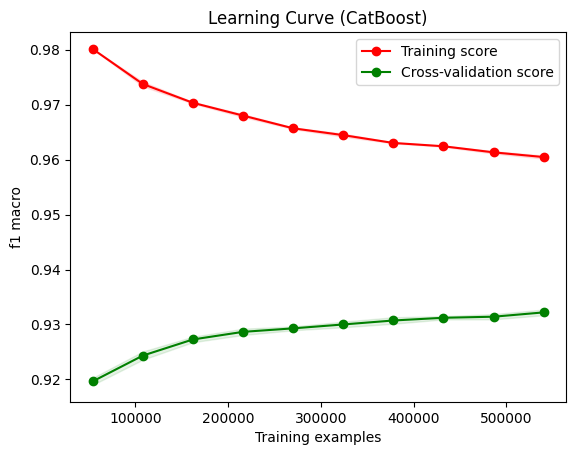

In [21]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = xgboost_pipeline,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'f1_macro'
)

#recuperation des moyennes et des écarts types(facultatif) à chaque cv
train_scores_mean = train_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis = 1)


plt.figure()
plt.title("Learning Curve (CatBoost)")
plt.xlabel("Training examples")
plt.ylabel("f1 macro")
#plt.gca().invert_yaxis() #inverser y car métrique de perte

# afficher les points
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

# relier les points
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")


plt.legend()
plt.show()